[Sklearn Time-Related feature engineering](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from paths import path, tpath, filestpath, mpath, filesmpath
from custom_transformers import make_stable_values_null, festivos, rain_categories_transformer, school_holidays, season, day_type

from sklearn import set_config
set_config(display='diagram')

from sklearn.model_selection import TimeSeriesSplit

id_t = 1001
variable_objetivo = "intensidad"


tmagns = ['intensidad', 'ocupacion', 'vmed']
mmagns = ['temperatura', 'humedad_relativa', 'presion_barometrica', 'radiacion_solar',
          'precipitacion', 'vientox', 'vientoy']

# Datos para hacer correspondencia entre estaciones de tráfico y meteorológicas
mapping = pd.read_csv(path + 'id_mapping.csv')
ids_m = mapping[mapping.id_t == id_t].iloc[0][[f'id_{magn}' for magn in mmagns]].astype(int)

# Leer los datos de tráfico
dft = pd.read_csv(filestpath + f'{id_t:.0f}.csv', parse_dates=['fecha'], index_col='fecha')
# Para cada estación, leemos los datos necesarios
dfm = {estacion: pd.read_csv(filesmpath + f'estacion-{estacion:.0f}.csv', parse_dates=['fecha'], index_col='fecha') for estacion in ids_m.unique()}


# Si hay más de 4 filas sin cambio, damos el valor por nulo
dft[tmagns] = dft[tmagns].apply(make_stable_values_null, nrows=4)

not_stable_columns = [col for col in mmagns if col not in ['precipitacion', 'radiacion_solar', 'presion_barometrica']]
for key, dfmi in dfm.items():
    dfm[key][not_stable_columns] = dfmi[not_stable_columns].apply(make_stable_values_null, nrows=4)


# Hacer el merge de todas las variables meteorológicas con el tráfico
df = dft
for m in mmagns:
    df = df.merge(dfm[ids_m[f"id_{m}"]][[m]],
                 left_index=True, right_index=True,
                how='left')

del dft, dfm

df[mmagns] = df[mmagns].interpolate(method="linear", limit=4)

df = df.reset_index()
df["viento"] = np.sqrt(df.vientox**2 + df.vientoy**2)
df["estacion"] = season(df.fecha)
df["festivo"] = df.fecha.dt.date.isin(festivos)
df["dia_semana"] = df.fecha.dt.weekday
df["dia_laborable"] = (df.dia_semana <= 4) & (~df.festivo)
df["tipo_dia"] = day_type(df.dia_semana)
df["vacaciones_escolares"] = school_holidays(df.fecha) | (~df.dia_laborable)
df["anyo"] = df.fecha.dt.year
df["mes"] = df.fecha.dt.month
df["dia"] = df.fecha.dt.day
df["hora"] = df.fecha.dt.hour + df.fecha.dt.minute/60

del df["fecha"]

df.head()

,intensidad,ocupacion,vmed,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy,...,estacion,festivo,dia_semana,dia_laborable,tipo_dia,vacaciones_escolares,anyo,mes,dia,hora
0,264.0,0.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,invierno,True,2,False,lunes-viernes,True,2020,1,1,0.00
1,252.0,0.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,invierno,True,2,False,lunes-viernes,True,2020,1,1,0.25
2,252.0,0.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,invierno,True,2,False,lunes-viernes,True,2020,1,1,0.50
3,744.0,1.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,invierno,True,2,False,lunes-viernes,True,2020,1,1,0.75
4,1212.0,2.0,62.0,1.1,97.0,955.0,1.0,0.0,-0.163056,0.608533,...,invierno,True,2,False,lunes-viernes,True,2020,1,1,1.00


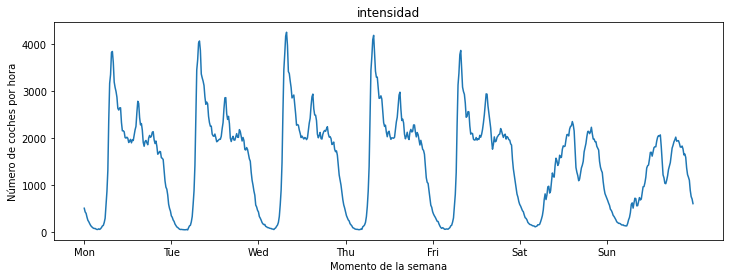

In [2]:
variable_objetivo = "intensidad"

fig, ax = plt.subplots(figsize=(12, 4))
titulos = {
    "intensidad": "Número de coches por hora",
    "ocupacion": "Porcentaje del tiempo en que la vía está ocupada",
    "vmed": "Velocidad media (Km/h)"
}
df.groupby(["dia_semana", "hora"]).mean()[variable_objetivo].plot(ax=ax)
_ = ax.set(
    title=variable_objetivo,
    xticks=[i * 4* 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Momento de la semana",
    ylabel=titulos[variable_objetivo],
)

#del df["weekday"], df["hour"]

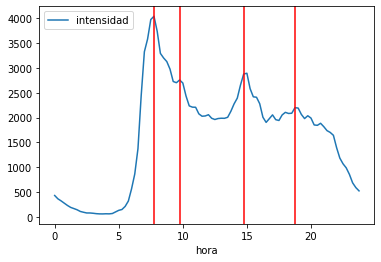

In [3]:
df[df.dia_semana<=4].groupby("hora").agg({"intensidad": "mean"}).plot()
plt.axvline(7.75, c="red") # 7:45
plt.axvline(9.75, c="red") # 9:45
plt.axvline(14.75, c="red") # 14:45
plt.axvline(18.75, c="red") # 18:45
plt.show()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58970 entries, 0 to 58969
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   intensidad            49876 non-null  float64
 1   ocupacion             42276 non-null  float64
 2   vmed                  49732 non-null  float64
 3   temperatura           57480 non-null  float64
 4   humedad_relativa      56043 non-null  float64
 5   presion_barometrica   49591 non-null  float64
 6   radiacion_solar       57499 non-null  float64
 7   precipitacion         55582 non-null  float64
 8   vientox               57499 non-null  float64
 9   vientoy               57499 non-null  float64
 10  viento                57499 non-null  float64
 11  estacion              58970 non-null  object 
 12  festivo               58970 non-null  bool   
 13  dia_semana            58970 non-null  int64  
 14  dia_laborable         58970 non-null  bool   
 15  tipo_dia           

In [5]:
for m in tmagns:
    if m != variable_objetivo:
        del df[m]
df = df.dropna().reset_index(drop=True)

El objetivo de la predicción es la intensidad de tráfico (número de coches por hora) 

In [6]:
df[variable_objetivo].max()

6600.0

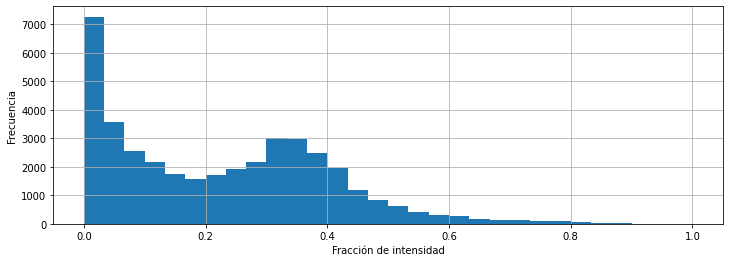

In [7]:
y = df[variable_objetivo] / df[variable_objetivo].max()

fig, ax = plt.subplots(figsize=(12, 4))
y.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel=f"Fracción de {variable_objetivo}",
    ylabel="Frecuencia",
)

In [8]:
X = df.drop(["intensidad"], axis="columns")
X

,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy,viento,estacion,festivo,dia_semana,dia_laborable,tipo_dia,vacaciones_escolares,anyo,mes,dia,hora
0,1.10,97.00,955.0,1.0,0.0,-0.163056,0.608533,0.630000,invierno,True,2,False,lunes-viernes,True,2020,1,1,1.00
1,0.95,97.25,955.0,1.0,0.0,0.000221,0.393976,0.393976,invierno,True,2,False,lunes-viernes,True,2020,1,1,1.25
2,0.80,97.50,955.0,1.0,0.0,0.163499,0.179419,0.242741,invierno,True,2,False,lunes-viernes,True,2020,1,1,1.50
3,0.65,97.75,955.0,1.0,0.0,0.326776,-0.035138,0.328660,invierno,True,2,False,lunes-viernes,True,2020,1,1,1.75
4,0.50,98.00,955.0,1.0,0.0,0.490054,-0.249695,0.550000,invierno,True,2,False,lunes-viernes,True,2020,1,1,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39534,6.25,91.50,961.0,1.0,0.0,0.422571,0.175148,0.457431,invierno,False,4,True,lunes-viernes,True,2021,12,31,22.75
39535,5.70,93.00,961.0,1.0,0.0,0.413445,0.201651,0.460000,invierno,False,4,True,lunes-viernes,True,2021,12,31,23.00
39536,5.70,93.00,961.0,1.0,0.0,0.413445,0.201651,0.460000,invierno,False,4,True,lunes-viernes,True,2021,12,31,23.25
39537,5.70,93.00,961.0,1.0,0.0,0.413445,0.201651,0.460000,invierno,False,4,True,lunes-viernes,True,2021,12,31,23.50


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39539 entries, 0 to 39538
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperatura           39539 non-null  float64
 1   humedad_relativa      39539 non-null  float64
 2   presion_barometrica   39539 non-null  float64
 3   radiacion_solar       39539 non-null  float64
 4   precipitacion         39539 non-null  float64
 5   vientox               39539 non-null  float64
 6   vientoy               39539 non-null  float64
 7   viento                39539 non-null  float64
 8   estacion              39539 non-null  object 
 9   festivo               39539 non-null  bool   
 10  dia_semana            39539 non-null  int64  
 11  dia_laborable         39539 non-null  bool   
 12  tipo_dia              39539 non-null  object 
 13  vacaciones_escolares  39539 non-null  bool   
 14  anyo                  39539 non-null  int64  
 15  mes                

In [10]:
45*4*24 # para ver qué tamano aprox de test utilizo - mes y medio

4320

In [11]:
2*4*24 # para ver aprox el "gap" entre train y test - dos días

192

In [12]:
from sklearn.model_selection import TimeSeriesSplit
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=192,
    max_train_size=10000,
    test_size=4320,
)

all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]

,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy,viento,estacion,festivo,dia_semana,dia_laborable,tipo_dia,vacaciones_escolares,anyo,mes,dia,hora
17939,8.950,93.00,960.75,1.0,0.0,-0.001416,-0.518600,0.518602,otono,False,0,True,lunes-viernes,False,2020,12,21,20.25
17940,9.000,93.00,960.50,1.0,0.0,0.092675,-0.495555,0.504146,otono,False,0,True,lunes-viernes,False,2020,12,21,20.50
17941,9.050,93.00,960.25,1.0,0.0,0.186766,-0.472510,0.508082,otono,False,0,True,lunes-viernes,False,2020,12,21,20.75
17942,9.100,93.00,960.00,1.0,0.0,0.280857,-0.449465,0.530000,otono,False,0,True,lunes-viernes,False,2020,12,21,21.00
17943,9.050,93.25,960.75,1.0,0.0,0.120078,-0.415826,0.432816,otono,False,0,True,lunes-viernes,False,2020,12,21,21.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22254,25.175,24.75,942.00,163.0,0.0,-4.248872,-1.494366,4.504003,primavera,False,5,False,sabado,True,2021,5,8,20.25
22255,24.950,24.50,942.00,137.0,0.0,-4.198987,-1.164017,4.357342,primavera,False,5,False,sabado,True,2021,5,8,20.50
22256,24.725,24.25,942.00,111.0,0.0,-4.149101,-0.833669,4.232026,primavera,False,5,False,sabado,True,2021,5,8,20.75
22257,24.500,24.00,942.00,85.0,0.0,-4.099216,-0.503320,4.130000,primavera,False,5,False,sabado,True,2021,5,8,21.00


In [13]:
X.iloc[train_0]

,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy,viento,estacion,festivo,dia_semana,dia_laborable,tipo_dia,vacaciones_escolares,anyo,mes,dia,hora
7747,12.450,66.50,948.50,337.0,0.0,-0.343431,1.792159,1.824768,primavera,False,6,False,domingo,True,2020,4,5,10.50
7748,12.525,65.75,948.75,356.0,0.0,-0.484261,1.803777,1.867651,primavera,False,6,False,domingo,True,2020,4,5,10.75
7749,12.600,65.00,949.00,375.0,0.0,-0.625091,1.815396,1.920000,primavera,False,6,False,domingo,True,2020,4,5,11.00
7750,12.800,64.75,949.00,397.0,0.0,-0.656369,1.803389,1.919123,primavera,False,6,False,domingo,True,2020,4,5,11.25
7751,19.150,46.50,946.00,351.5,0.0,-2.435181,0.628203,2.514905,primavera,False,6,False,domingo,True,2020,4,5,18.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17742,7.900,99.00,954.00,1.0,0.0,-1.018234,1.018234,1.440000,otono,False,5,False,sabado,True,2020,12,19,19.00
17743,8.000,98.75,954.00,1.0,0.0,-0.902991,0.825703,1.223592,otono,False,5,False,sabado,True,2020,12,19,19.25
17744,8.100,98.50,954.00,1.0,0.0,-0.787748,0.633172,1.010670,otono,False,5,False,sabado,True,2020,12,19,19.50
17745,8.200,98.25,954.00,1.0,0.0,-0.672505,0.440640,0.804007,otono,False,5,False,sabado,True,2020,12,19,19.75


In [80]:
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, KBinsDiscretizer, PowerTransformer,\
                                  QuantileTransformer, FunctionTransformer, SplineTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import RidgeCV
from sklearn.kernel_approximation import Nystroem

from random import choice

In [47]:
precipitacion_one_hot = make_pipeline(
    rain_categories_transformer,
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)

precipitacion_ordinal = make_pipeline(
    rain_categories_transformer,
    OrdinalEncoder(categories=[["no_rain", "moderate_rain", "strong_rain"]]),
)

columns_viento = dict(xy=["vientox", "vientoy"], cantidad=["viento"])

precipitacion_transformer = dict(
    one_hot=precipitacion_one_hot,
    ordinal=precipitacion_ordinal,
    numerico_power=PowerTransformer(method='yeo-johnson'),
    numerico_quantile_uniform=QuantileTransformer(output_distribution="uniform"),
    numerico_quantile_normal=QuantileTransformer(output_distribution="normal"),
)

estacion_transformer = dict(
    ordinal=OrdinalEncoder(categories=[["verano", "primavera", "otono", "invierno"]])
)

bool_columns = ["festivo", "dia_laborable", "vacaciones_escolares"]
bool_categories = [[False, True]] * len(bool_columns)

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

def sincos(period):
    return FeatureUnion([
        ("sin", sin_transformer(period)),
        ("cos", cos_transformer(period))
    ])


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

period_dict = dict(
    mes=12,
    dia_semana=7,
    dia=31,
    hora=24
)

def transformer_temporal(approach, period):
    if approach == "numeric":
        return "passthrough"
    elif approach == "one_hot":
        return OneHotEncoder(handle_unknown="ignore", sparse=False)
    elif approach == "trigonometric":
        return sincos(period)
    elif approach == "spline":
        return periodic_spline_transformer(period, n_splines=period//2)

def transformer_hora(approach):
    if approach == "one_hot":
        return make_pipeline(
            KBinsDiscretizer(n_bins=24, encode="ordinal"),
            transformer_temporal(hora, period_dict["hora"])
        )
    else:
        return transformer_temporal(hora, period_dict["hora"])
    
def hour_workday_interaction(hora):
    return make_pipeline(
        ColumnTransformer([
            ("marginal", transformer_hora(hora), ["hora"]),
            ("workingday", FunctionTransformer(lambda x: x == True), ["dia_laborable"])
        ]),
        PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    )

In [81]:
passthrough_columns = ["temperatura", "humedad_relativa", "presion_barometrica", "radiacion_solar", "anyo"]
def preprocessing_transformer(precipitacion, viento, estacion, dia_semana, mes, dia, hora):
    return ColumnTransformer(transformers=[
        ("passthrough", "passthrough", passthrough_columns),
        ("precipitacion", precipitacion_transformer.get(precipitacion), ["precipitacion"]),
        ("viento", "passthrough", columns_viento.get(viento)),
        ("estacion", estacion_transformer.get(estacion), ["estacion"]),
        ("bool", OrdinalEncoder(categories=bool_categories), bool_columns),
        #("temporal", temporal_preprocessing(dia_semana, mes, dia, hora), ["dia_semana", "mes", "dia", "hora"])
        ("dia_semana", transformer_temporal(dia_semana, period_dict["dia_semana"]), ["dia_semana"]),
        ("mes", transformer_temporal(mes, period_dict["mes"]), ["mes"]),
        ("dia", transformer_temporal(dia, period_dict["dia"]), ["dia"]),
        ("hora", transformer_hora(hora), ["hora"]),
    ])

def step1(precipitacion, viento, estacion, dia_semana, mes, dia, hora, interactions):
    preprocessing = preprocessing_transformer(precipitacion, viento, estacion, dia_semana, mes, dia, hora)
    if interactions=="poly":
        return FeatureUnion([
            ("marginal", preprocessing),
            ("interactions", hour_workday_interaction(hora))
        ])
    elif interactions=="kernel":
        return make_pipeline(
            preprocessing,
             Nystroem(kernel="poly", degree=2, n_components=300, random_state=0)
        )
    else:
        return preprocessing

prediction_dict = {
    "ridgecv": RidgeCV(),
    "GradientBoosting": HistGradientBoostingRegressor()
}

# range of possible values
# precipitacion: one_hot, ordinal, numerico_power, numerico_quantile_uniform, numerico_quantile_normal
precipitacion_v = ["one_hot", "ordinal", "numerico_power", "numerico_quantile_uniform", "numerico_quantile_normal"]
# viento: xy, cantidad
viento_v = ["xy", "cantidad"]
# estacion: drop, ordinal
estacion_v = ["ordinal"]
# dia_semana, mes, dia, hora: numeric, one_hot, trigonometric, spline
temporal_v = ["numeric", "one_hot", "trigonometric", "spline"]
# prediction: ridgecv, GradientBoosting
prediction_v = ["ridgecv", "GradientBoosting"]
interactions_v = [False, "poly", "kernel"]

def predicting_pipeline(precipitacion, viento, estacion, dia_semana, mes, dia, hora, prediction, interactions):
    return Pipeline(steps=[
        #("preprocessing", preprocessing_transformer(precipitacion, viento, estacion, dia_semana, mes, dia, hora)),
        ("preprocessing", step1(precipitacion, viento, estacion, dia_semana, mes, dia, hora, interactions)),
        ("scaler", StandardScaler()),
        ("prediction", prediction_dict.get(prediction))
    ])

In [82]:
precipitacion = choice(precipitacion_v)
viento = choice(viento_v)
estacion = choice(estacion_v)
dia_semana = choice(temporal_v)
mes = choice(temporal_v)
dia = choice(temporal_v)
hora = choice(temporal_v)
prediction = choice(prediction_v)
interactions = choice(interactions_v)

predicting_pipeline(precipitacion=precipitacion, viento=viento, estacion=estacion, prediction=prediction, dia_semana=dia_semana, mes=mes, dia=dia, hora=hora, interactions=interactions)

Pipeline(steps=[('preprocessing',
                 FeatureUnion(transformer_list=[('marginal',
                                                 ColumnTransformer(transformers=[('passthrough',
                                                                                  'passthrough',
                                                                                  ['temperatura',
                                                                                   'humedad_relativa',
                                                                                   'presion_barometrica',
                                                                                   'radiacion_solar',
                                                                                   'anyo']),
                                                                                 ('precipitacion',
                                                                                  QuantileTransformer(output_distribution='normal'),
                                                                                  ['precipitacion']),
                                                                                 ('viento',
                                                                                  'passthrough',
                                                                                  ['viento']),
                                                                                 ('estaci...
                                                                                                                                   FunctionTransformer(func=<function cos_transformer.<locals>.<lambda> at 0x7f19bc32cee0>))]),
                                                                                                   ['hora']),
                                                                                                  ('workingday',
                                                                                                   FunctionTransformer(func=<function hour_workday_interaction.<locals>.<lambda> at 0x7f19bc32c940>),
                                                                                                   ['dia_laborable'])])),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(include_bias=False,
                                                                                     interaction_only=True))]))])),
                ('scaler', StandardScaler()),
                ('prediction', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [83]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [84]:
class traffic_predictor(BaseEstimator, ClassifierMixin):
    def __init__(self, precipitacion, viento, estacion, dia_semana, mes, dia, hora, prediction, interactions):
        self.dia = dia
        self.dia_semana = dia_semana
        self.precipitacion = precipitacion
        self.viento = viento
        self.estacion = estacion
        self.mes = mes
        self.hora = hora
        self.prediction = prediction
        self.interactions = interactions
        self.pipeline = predicting_pipeline(precipitacion, viento, estacion, dia_semana, mes, dia, hora, prediction, interactions)
        self._estimator_type = "regressor"
    def fit(self, X, y):
        self.pipeline.fit(X, y)
        #return self
    def predict(self, X):
        return self.pipeline.predict(X)
    def transform(self, X):
        return self.pipeline.transform(X)
    def set_params(self, **parameters):
        for a in ["precipitacion", "viento", "estacion", "dia_semana", "mes", "dia", "hora", "prediction", "interactions"]:
            if a in parameters.keys():
                setattr(self, a, parameters[a])
        #BaseEstimator.set_params(self, **parameters)
        self.pipeline = predicting_pipeline(self.precipitacion, self.viento, self.estacion, self.dia_semana, self.mes, self.dia, self.hora, self.prediction, self.interactions)
        #for parameter, value in parameters.items():
        #    setattr(self, parameter, value)
        return self
    def score(self, X, y):
        return self.pipeline.score(X, y)

In [85]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    result = f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\nRoot Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    return mae, rmse

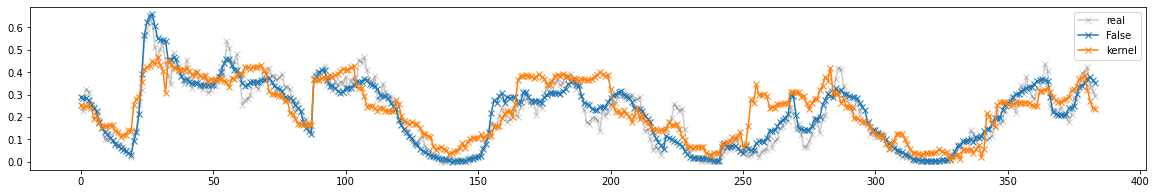

In [89]:
fig, ax = plt.subplots(figsize=(20, 3))

train_set, test_set = all_splits[0]
ax.plot(y.iloc[test_set][:4*4*24].reset_index(drop=True), "x-", alpha=0.2, label="real", color="black")

parameters = {}
for i in range(2):
    precipitacion = choice(precipitacion_v)
    viento = choice(viento_v)
    estacion = choice(estacion_v)
    dia_semana = choice(temporal_v)
    mes = choice(temporal_v)
    dia = choice(temporal_v)
    hora = choice(temporal_v)
    prediction = choice(prediction_v)
    interactions = choice(interactions_v)
    
    parameters[i] = {
        "precipitacion" : precipitacion,
        "viento": viento,
        "estacion": estacion,
        "dia_semana": dia_semana,
        "mes": mes,
        "dia": dia,
        "hora": hora,
        "prediction": prediction,
        "interactions": interactions
    }

    precipitacion_columns = {
        "one_hot": ["no_rain", "moderate_rain", "strong_rain"]
    }

    estacion_columns  = {
        "drop": [],
        "ordinal": ["estacion"]
    }
    def temp_columns(dimension, approach):
        if approach == "numeric":
            return [dimension]
        elif approach == "one_hot":
            return [f"{dimension}_{i+1}" for i in range(period_dict[dimension])]
        elif approach == "spline":
            return [f"{dimension}_{i+1}" for i in range(period_dict[dimension]//2)]
        elif approach == "drop":
            return []
        else:
            return [f"sin_{dimension}", f"cos_{dimension}"]
        
    interactions_columns = {
        False: [],
        "poly": ["workingday_hour_interaction"],
        "kernel": []
    }

    features = passthrough_columns + precipitacion_columns.get(precipitacion, ["precipitacion"]) + columns_viento[viento] + estacion_columns[estacion] + bool_columns\
               + temp_columns("dia_semana", dia_semana) + temp_columns("mes", mes) + temp_columns("dia", dia) + temp_columns("hora", hora) + interactions_columns[interactions]

    pipeline = traffic_predictor(precipitacion=precipitacion, viento=viento, estacion=estacion, prediction=prediction,
                                   dia_semana=dia_semana, mes=mes, dia=dia, hora=hora, interactions=interactions)
    pipeline.fit(X, y)
    ax.plot(pipeline.predict(X.iloc[test_set])[:4*4*24], "x-", label=interactions)
    #mae, rmse = evaluate(pipeline, X, y, cv=ts_cv)
    #parameters[i]["mae"] = f"{mae.mean():.3f} +/- {mae.std():.3f}"
    #parameters[i]["rmse"] = f"{rmse.mean():.3f} +/- {rmse.std():.3f}"
    #ax.set_title(f"{prediction}\nmae:{parameters[i]['mae']}\nrmse:{parameters[i]['rmse']}")


plt.legend()
plt.show()

In [90]:
pd.DataFrame(parameters).transpose()

,precipitacion,viento,estacion,dia_semana,mes,dia,hora,prediction,interactions
0,one_hot,cantidad,ordinal,trigonometric,numeric,one_hot,trigonometric,GradientBoosting,False
1,numerico_quantile_uniform,xy,ordinal,numeric,spline,numeric,spline,GradientBoosting,kernel


## Are results better with interactions?

In [ ]:
mae = {False: [], "kernel": []}
rmse = {False: [], "kernel": []}

for i in range(10):
    precipitacion = choice(precipitacion_v)
    viento = choice(viento_v)
    estacion = choice(estacion_v)
    dia_semana = choice(temporal_v)
    mes = choice(temporal_v)
    dia = choice(temporal_v)
    hora = choice(temporal_v)
    prediction = "ridgecv"#choice(prediction_v)
    
    for interactions in [False, "kernel"]:
        pipeline = traffic_predictor(precipitacion=precipitacion, viento=viento, estacion=estacion, prediction=prediction,
                                       dia_semana=dia_semana, mes=mes, dia=dia, hora=hora, interactions=interactions)
        maei, rmsei= evaluate(pipeline, X, y, cv=ts_cv)
        mae[interactions].append(maei.mean())
        rmse[interactions].append(rmsei.mean())

In [ ]:
r = pd.DataFrame(mae)
r["dif"] = r["kernel"] - r[False]
r

In [ ]:
r.dif.median()

In [77]:
r = pd.DataFrame(mae)
r["dif"] = r[True] - r[False]
r

,False,True,dif
0,0.097676,0.084355,-0.013320
1,0.083705,0.065566,-0.018139
2,0.117819,0.118125,0.000306
3,0.098514,0.085327,-0.013186
4,0.108341,0.097862,-0.010479
5,0.112286,0.118510,0.006224
6,0.112282,0.118521,0.006238
7,0.084248,0.064141,-0.020107
8,0.083215,0.064715,-0.018501
9,0.113523,0.104448,-0.009074


In [79]:
r.dif.median()

-0.011832913907451031

In [72]:
rmse

{False: [0.1296188714770911], True: [0.10748759552912701]}

In [44]:
pipeline.set_params(precipitacion="one_hot")

traffic_predictor(dia='one_hot', dia_semana='spline', estacion='ordinal',
                  hora='one_hot', mes='spline', precipitacion='one_hot',
                  prediction='ridgecv', viento='xy')

In [45]:
pipeline.pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['temperatura',
                                                   'humedad_relativa',
                                                   'presion_barometrica',
                                                   'radiacion_solar', 'anyo']),
                                                 ('precipitacion',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function rain_categories at 0x7f19bda65280>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='i...
       [12.]]),
                                                                    n_knots=7),
                                                  ['mes']),
                                                 ('dia',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['dia']),
                                                 ('hora',
                                                  Pipeline(steps=[('kbinsdiscretizer',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=24)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['hora'])])),
                ('scaler', StandardScaler()),
                ('prediction', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
reg = traffic_predictor(precipitacion, viento, estacion, dia_semana, mes, dia, hora, prediction)
parameters = dict(
    precipitacion__key=precipitacion_v,
    viento=viento_v,
    estacion=estacion_v,
    dia_semana=temporal_v,
    dia=temporal_v,
    hora=temporal_v,
    mes=temporal_v,
    prediction=prediction_v
)
clf = GridSearchCV(reg, parameters, cv=ts_cv)
clf.fit(X, y)

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values("rank_test_score").head().loc[:, :"param_dia"]

In [ ]:
pd.DataFrame(clf.cv_results_).sort_values("rank_test_score").tail().loc[:, :"param_dia"]

In [ ]:
pd.DataFrame(clf.cv_results_).to_csv("gridsearch_results.csv")

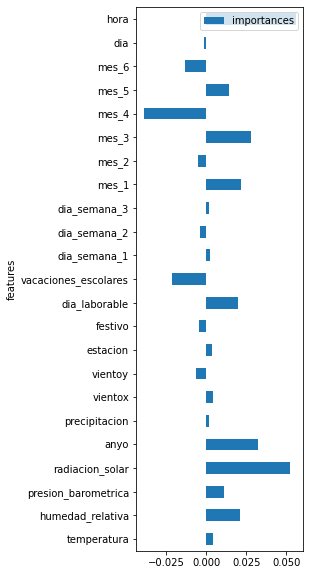

In [24]:
coefs = pipeline[-1].coef_
fig, ax = plt.subplots(figsize=(3, 10))
pd.DataFrame(zip(coefs, features)).rename(columns={0: "importances", 1: "features"}).plot.barh(x=1, ax=ax)
plt.show()

In [ ]:
pd.DataFrame(zip(cyclic_cossin_linear_pipeline[1].coef_, features)).plot.barh(x=1, ax=ax)


In [269]:
evaluate(pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.066 +/- 0.036
Root Mean Squared Error: 0.091 +/- 0.046


In [271]:
evaluate(pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.076 +/- 0.030
Root Mean Squared Error: 0.109 +/- 0.041


In [273]:
evaluate(pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.070 +/- 0.026
Root Mean Squared Error: 0.105 +/- 0.036


In [275]:
evaluate(pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.109 +/- 0.025
Root Mean Squared Error: 0.141 +/- 0.028


In [245]:
xt.shape

(39539, 38)

In [246]:
evaluate(pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.078 +/- 0.033
Root Mean Squared Error: 0.112 +/- 0.043


In [197]:
evaluate(pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.127 +/- 0.028
Root Mean Squared Error: 0.165 +/- 0.031


In [202]:
evaluate(pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.119 +/- 0.048
Root Mean Squared Error: 0.162 +/- 0.066


In [205]:
pipeline.predict(X.iloc[test_0])[:4*4*24]

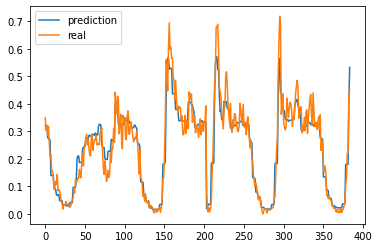

In [247]:
_, test_set = all_splits[2]
plt.plot(pipeline.predict(X.iloc[test_set])[:4*4*24], label="prediction")
plt.plot(y.iloc[test_set][:4*4*24].reset_index(drop=True), label="real")
plt.legend()
plt.show()

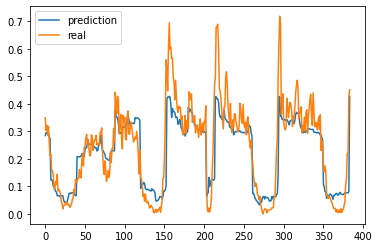

In [219]:
_, test_set = all_splits[2]
plt.plot(pipeline.predict(X.iloc[test_set])[:4*4*24], label="prediction")
plt.plot(y.iloc[test_set][:4*4*24].reset_index(drop=True), label="real")
plt.legend()
plt.show()

In [213]:
y.iloc[test_0][:4*4*24].reset_index(drop=True)

0       0.380000
1       0.305455
2       0.367273
3       0.374545
4       0.338182
          ...   
4295    0.234545
4296    0.174545
4297    0.150000
4298    0.230909
4299    0.205455
Name: intensidad, Length: 4300, dtype: float64

In [128]:
for t in pipeline.transformer_list:
    print(t[1].transformers_)

[('escaler', StandardScaler(), ['temperatura', 'humedad_relativa', 'presion_barometrica', 'radiacion_solar']), ('remainder', 'drop', [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])]
[('precipitacion', Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function rain_categories at 0x7f9b9325f430>)),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['no_rain', 'moderate_rain',
                                             'strong_rain']]))]), ['precipitacion']), ('remainder', 'drop', [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])]
[('viento', 'passthrough', ['vientox', 'vientoy']), ('remainder', 'drop', [0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])]
[('estacion', 'drop', ['estacion']), ('remainder', 'drop', [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17])]


In [100]:
preprocessing_pipeline(precipitacion="ordinal", viento="cantidad").fit_transform(X).shape

(39539, 6)

In [109]:
preprocessing_pipeline(precipitacion="ordinal", viento="xy", estacion="drop")

FeatureUnion(transformer_list=[('escaler',
                                ColumnTransformer(transformers=[('escaler',
                                                                 StandardScaler(),
                                                                 ['temperatura',
                                                                  'humedad_relativa',
                                                                  'presion_barometrica',
                                                                  'radiacion_solar'])])),
                               ('precipitacion',
                                ColumnTransformer(transformers=[('precipitacion',
                                                                 Pipeline(steps=[('functiontransformer',
                                                                                  FunctionTransformer(func=<function rain_categories at 0x7f9b9325f430>)),
                                                                                 ('ordinalencoder',
                                                                                  OrdinalEncoder(categories=[['no_rain',
                                                                                                              'moderate_rain',
                                                                                                              'strong_rain']]))]),
                                                                 ['precipitacion'])])),
                               ('viento',
                                ColumnTransformer(transformers=[('viento',
                                                                 'passthrough',
                                                                 ['vientox',
                                                                  'vientoy'])])),
                               ('estacion',
                                ColumnTransformer(transformers=[('estacion',
                                                                 'drop',
                                                                 ['estacion'])]))])

In [91]:
np.unique(rain_categories_transformer.transform(df.precipitacion), return_counts=True)

(array(['heavy_rain', 'light_rain', 'moderate_rain', 'no_rain'],
       dtype='<U13'),
 array([   19,  2480,   150, 36890]))

# Gradient Boosting

In [173]:


categorical_columns = [
    "precipitacion",
    "holiday",
    "estacion",
    "dia_laborable",
    "vac_escolares"
]
categories = [
    ["seco", "ligera", "moderada", "fuerte"],
    [False, True],
    ["primavera", "verano", "otono", "invierno"],
    [False, True],
    [False, True]
]


ordinal_encoder = OrdinalEncoder(categories=categories)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
    ),
    HistGradientBoostingRegressor(
        categorical_features=range(4)
    )
)

In [118]:
X

,temperatura,humedad_relativa,radiacion_solar,precipitacion,vientox,vientoy,holiday,estacion,dia_laboral,vac_escolares,year,month,hour,weekday
0,1.10,97.00,1.0,seco,-0.163056,0.608533,True,invierno,False,True,2020,1,1.00,2
1,0.95,97.25,1.0,seco,0.000221,0.393976,True,invierno,False,True,2020,1,1.25,2
2,0.80,97.50,1.0,seco,0.163499,0.179419,True,invierno,False,True,2020,1,1.50,2
3,0.65,97.75,1.0,seco,0.326776,-0.035138,True,invierno,False,True,2020,1,1.75,2
4,0.50,98.00,1.0,seco,0.490054,-0.249695,True,invierno,False,True,2020,1,2.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47972,6.25,91.50,1.0,seco,0.422571,0.175148,False,invierno,True,True,2021,12,22.75,4
47973,5.70,93.00,1.0,seco,0.413445,0.201651,False,invierno,True,True,2021,12,23.00,4
47974,5.70,93.00,1.0,seco,0.413445,0.201651,False,invierno,True,True,2021,12,23.25,4
47975,5.70,93.00,1.0,seco,0.413445,0.201651,False,invierno,True,True,2021,12,23.50,4


In [119]:
df.dtypes

fecha               datetime64[ns]
intensidad                 float64
temperatura                float64
humedad_relativa           float64
radiacion_solar            float64
precipitacion               object
vientox                    float64
vientoy                    float64
holiday                       bool
estacion                    object
dia_laboral                   bool
vac_escolares                 bool
dtype: object

In [120]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"]
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}\n"
    )
    return cv_results
    
evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.046 +/- 0.014
Root Mean Squared Error: 0.066 +/- 0.020



{'fit_time': array([1.85808039, 1.18265939, 2.6046617 , 2.54766417, 1.5965066 ]),
 'score_time': array([0.0416069 , 0.03958631, 0.09647751, 0.05181527, 0.06275749]),
 'test_neg_mean_absolute_error': array([-0.03102067, -0.03619587, -0.05458668, -0.06874752, -0.04125751]),
 'test_neg_root_mean_squared_error': array([-0.04389241, -0.04994174, -0.07487768, -0.09857479, -0.06144162])}

# Naive linear regression

In [121]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns)
        ],
        remainder=MinMaxScaler()
    ),
    RidgeCV(alphas=alphas)
)

evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.130 +/- 0.006
Root Mean Squared Error: 0.165 +/- 0.008



{'fit_time': array([0.25358248, 0.20673323, 0.3262589 , 0.34372783, 0.30871081]),
 'score_time': array([0.0542891 , 0.02472186, 0.02208972, 0.02775359, 0.02441597]),
 'test_neg_mean_absolute_error': array([-0.13437448, -0.13200798, -0.12384039, -0.12198821, -0.13597331]),
 'test_neg_root_mean_squared_error': array([-0.16728413, -0.16841473, -0.14922941, -0.16463853, -0.17409888])}

In [122]:
naive_linear_pipeline[0]

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['precipitacion', 'holiday', 'estacion',
                                  'dia_laboral', 'vac_escolares'])])

In [123]:
xt = naive_linear_pipeline[0].fit_transform(X[categorical_columns])
#naive_linear_pipeline[0].get_features_names_out()

In [124]:
naive_linear_pipeline[0].get_feature_names_out()

array(['categorical__precipitacion_fuerte',
       'categorical__precipitacion_ligera',
       'categorical__precipitacion_moderada',
       'categorical__precipitacion_seco', 'categorical__holiday_False',
       'categorical__holiday_True', 'categorical__estacion_invierno',
       'categorical__estacion_otono', 'categorical__estacion_primavera',
       'categorical__estacion_verano', 'categorical__dia_laboral_False',
       'categorical__dia_laboral_True',
       'categorical__vac_escolares_False',
       'categorical__vac_escolares_True'], dtype=object)

In [125]:
naive_linear_pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['precipitacion', 'holiday',
                                                   'estacion', 'dia_laboral',
                                                   'vac_escolares'])])),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

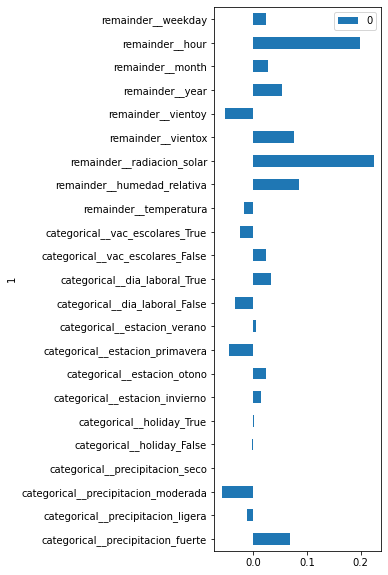

In [126]:
fig, ax = plt.subplots(figsize=(3, 10))
pd.DataFrame(zip(naive_linear_pipeline[1].coef_, naive_linear_pipeline[0].get_feature_names_out())).plot.barh(x=1, ax=ax)
plt.show()

# Time-steps as categories

In [127]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline

In [128]:
hour_pipeline = Pipeline([
    ("round", KBinsDiscretizer(n_bins=24, encode="ordinal")),
    ("one_hot_hour", one_hot_encoder)
])

one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["weekday", "month"]),
            ("one_hot_hour", hour_pipeline, ["hour"])
        ],
        remainder=MinMaxScaler()
    ),
    RidgeCV(alphas=alphas)
)
evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.076 +/- 0.004
Root Mean Squared Error: 0.101 +/- 0.003



{'fit_time': array([0.58303642, 0.61668396, 0.92493844, 0.68803787, 0.46852517]),
 'score_time': array([0.04069567, 0.0480926 , 0.04760814, 0.05645704, 0.05596614]),
 'test_neg_mean_absolute_error': array([-0.07196408, -0.07779296, -0.08245009, -0.07459515, -0.07379308]),
 'test_neg_root_mean_squared_error': array([-0.09672229, -0.10175984, -0.10537566, -0.10225971, -0.10070691])}

In [129]:
one_hot_linear_pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['precipitacion', 'holiday',
                                                   'estacion', 'dia_laboral',
                                                   'vac_escolares']),
                                                 ('one_hot_time',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['weekday', 'month']),
                                                 ('one_hot_hour',
                                                  Pipeline(steps...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [130]:
t = one_hot_linear_pipeline[0]
t

ColumnTransformer(remainder=MinMaxScaler(),
                  transformers=[('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['precipitacion', 'holiday', 'estacion',
                                  'dia_laboral', 'vac_escolares']),
                                ('one_hot_time',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['weekday', 'month']),
                                ('one_hot_hour',
                                 Pipeline(steps=[('round',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=24)),
                                                 ('one_hot_hour',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['hour'])])

# Trigonometric features

In [131]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x/period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x/period * 2 * np.pi))

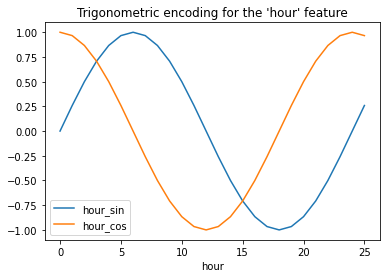

In [132]:
hour_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["hour"]
)
hour_df["hour_sin"] = sin_transformer(24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(24).fit_transform(hour_df)["hour"]
hour_df.plot(x="hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature")

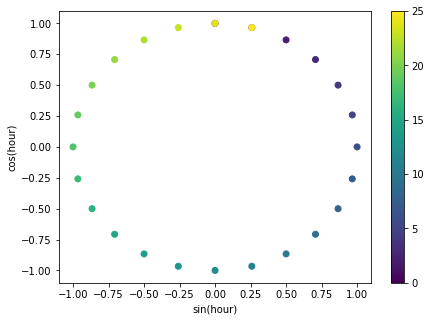

In [133]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(hour_df["hour_sin"], hour_df["hour_cos"], c=hour_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)"
)
_ = fig.colorbar(sp)

In [134]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder=MinMaxScaler()
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas)
)
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.147 +/- 0.070
Root Mean Squared Error: 0.181 +/- 0.076



{'fit_time': array([0.32251287, 0.31648564, 0.33093262, 0.30022812, 0.29353118]),
 'score_time': array([0.04313636, 0.05097842, 0.04019642, 0.04206204, 0.04249954]),
 'test_neg_mean_absolute_error': array([-0.12218492, -0.0990389 , -0.0966296 , -0.13537082, -0.28367889]),
 'test_neg_root_mean_squared_error': array([-0.14822356, -0.13278406, -0.11607866, -0.18257485, -0.32775835])}

In [135]:
cyclic_cossin_linear_pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['precipitacion', 'holiday',
                                                   'estacion', 'dia_laboral',
                                                   'vac_escolares']),
                                                 ('month_sin',
                                                  FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x7f1ec176a310>),
                                                  ['month']),
                                                 ('month_c...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [136]:
t = cyclic_cossin_linear_pipeline[0]

In [137]:
t.transformers_[0]

('categorical',
 OneHotEncoder(handle_unknown='ignore', sparse=False),
 ['precipitacion', 'holiday', 'estacion', 'dia_laboral', 'vac_escolares'])

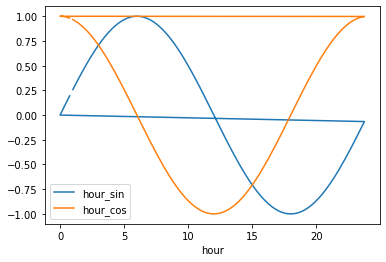

In [138]:
features = []
for ti in t.transformers_:
    try:
        ni = ti[1].n_features_out_
        fi = ti[1].get_feature_names_out()[:ni]
    except Exception:
        try:
            fi = ti[1].get_feature_names_out()
        except Exception:
            fi = [ti[0]]
    features += list(fi)
    
xt = pd.DataFrame(t.transform(X), columns=features)
pd.concat([X.hour, xt[[c for c in xt.columns if "hour" in c]].iloc[:4*24]], axis="columns").plot(x="hour")
plt.show()

In [139]:
np.cos(1/24*2*np.pi)

0.9659258262890683

<AxesSubplot:xlabel='hour'>

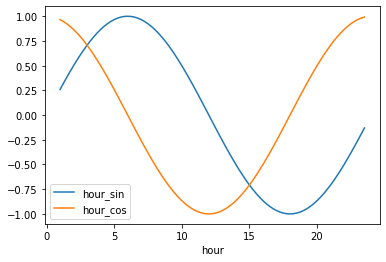

In [140]:
pd.concat([X.hour, xt[[c for c in xt.columns if "hour" in c]].iloc[:91]], axis="columns").dropna().plot(x="hour")

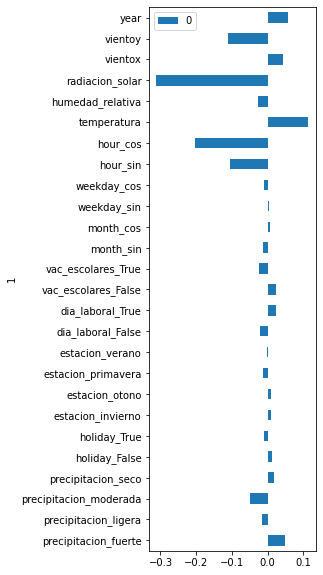

In [141]:
fig, ax = plt.subplots(figsize=(3, 10))
pd.DataFrame(zip(cyclic_cossin_linear_pipeline[1].coef_, features)).plot.barh(x=1, ax=ax)
plt.show()

# Periodic spline features

In [142]:
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True
    )

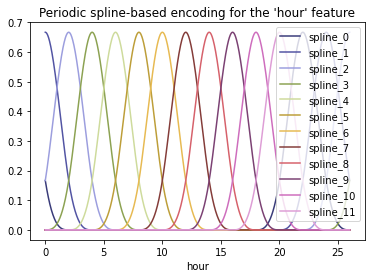

In [143]:
hour_df = pd.DataFrame(
    np.linspace(0, 26, 1000).reshape(-1, 1),
    columns=["hour"],
)
splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
pd.concat([hour_df, splines_df], axis="columns").plot(x="hour", cmap=plt.cm.tab20b)
_ = plt.title("Periodic spline-based encoding for the 'hour' feature")

In [144]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas)
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.105 +/- 0.027
Root Mean Squared Error: 0.136 +/- 0.034



{'fit_time': array([0.49457383, 0.41611385, 0.51165271, 0.39475441, 0.49772096]),
 'score_time': array([0.07184553, 0.06227112, 0.045964  , 0.07809687, 0.06801939]),
 'test_neg_mean_absolute_error': array([-0.07734892, -0.13935234, -0.08014515, -0.134297  , -0.09332899]),
 'test_neg_root_mean_squared_error': array([-0.10072867, -0.18805154, -0.10337258, -0.16322458, -0.12282201])}

In [145]:
cyclic_spline_linear_pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['precipitacion', 'holiday',
                                                   'estacion', 'dia_laboral',
                                                   'vac_escolares']),
                                                 ('cyclic_month',
                                                  SplineTransformer(extrapolation='periodic',
                                                                    knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.]]),
                                                                    n_knots=...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [146]:
t = cyclic_spline_linear_pipeline[0]

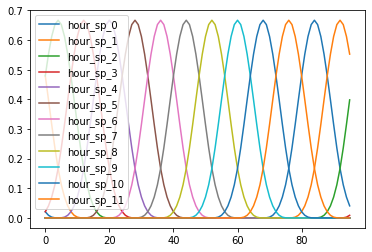

In [147]:
features = []
for ti in t.transformers_:
    try:
        ni = ti[1].n_features_out_
        fi = ti[1].get_feature_names_out()[:ni]
    except Exception:
        fi = ti[1].get_feature_names_out()
    features += list(fi)
    
xt = pd.DataFrame(t.transform(X), columns=features)
xt[[c for c in xt.columns if "hour" in c]].iloc[:4*24].plot()
plt.show()

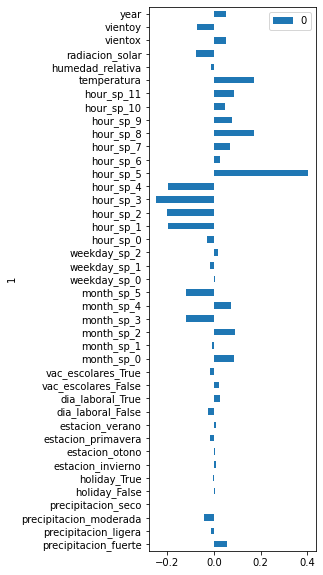

In [148]:
fig, ax = plt.subplots(figsize=(3, 10))
pd.DataFrame(zip(cyclic_spline_linear_pipeline[1].coef_, features)).plot.barh(x=1, ax=ax)
plt.show()

# Qualitatve analysis

In [164]:
train_set, test_set = all_splits[2]

naive_linear_pipeline.fit(X.iloc[train_set], y.iloc[train_set])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_set])

one_hot_linear_pipeline.fit(X.iloc[train_set], y.iloc[train_set])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_set])

cyclic_cossin_linear_pipeline.fit(X.iloc[train_set], y.iloc[train_set])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[test_set])

cyclic_spline_linear_pipeline.fit(X.iloc[train_set], y.iloc[train_set])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_set])

gbrt_pipeline.fit(X.iloc[train_set], y.iloc[train_set])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_set])

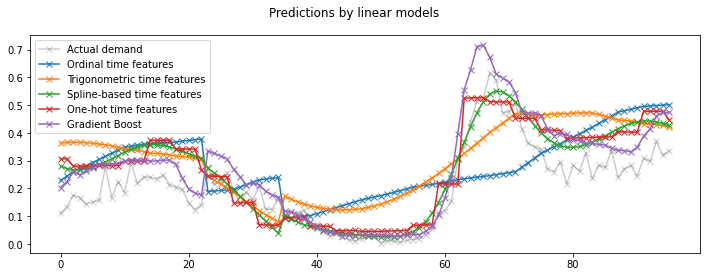

In [165]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_set].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(naive_linear_predictions[last_hours], "x-", label="Ordinal time features")
ax.plot(
    cyclic_cossin_linear_predictions[last_hours],
    "x-",
    label="Trigonometric time features",
)
ax.plot(
    cyclic_spline_linear_predictions[last_hours],
    "x-",
    label="Spline-based time features",
)
ax.plot(
    one_hot_linear_predictions[last_hours],
    "x-",
    label="One-hot time features",
)

ax.plot(
    gbrt_predictions[last_hours],
    "x-",
    label="Gradient Boost",
)
_ = ax.legend()

In [154]:
naive_linear_pipeline[:-1].transform(X).shape

(47977, 22)

In [155]:
one_hot_linear_pipeline[:-1].transform(X).shape

(47977, 55)

In [156]:
cyclic_cossin_linear_pipeline[:-1].transform(X).shape

(47977, 25)

In [157]:
cyclic_spline_linear_pipeline[:-1].transform(X).shape

(47977, 40)

# Pairwise interactions with splines and polynomial features

In [174]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion


hour_workday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("workingday", FunctionTransformer(lambda x: x == "True"), ["dia_laborable"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

In [175]:
X

,temperatura,humedad_relativa,radiacion_solar,precipitacion,vientox,vientoy,holiday,estacion,dia_laboral,vac_escolares,dia_laborable,year,month,hour,weekday
0,1.10,97.00,1.0,seco,-0.163056,0.608533,True,invierno,False,True,False,2020,1,1.00,2
1,0.95,97.25,1.0,seco,0.000221,0.393976,True,invierno,False,True,False,2020,1,1.25,2
2,0.80,97.50,1.0,seco,0.163499,0.179419,True,invierno,False,True,False,2020,1,1.50,2
3,0.65,97.75,1.0,seco,0.326776,-0.035138,True,invierno,False,True,False,2020,1,1.75,2
4,0.50,98.00,1.0,seco,0.490054,-0.249695,True,invierno,False,True,False,2020,1,2.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47972,6.25,91.50,1.0,seco,0.422571,0.175148,False,invierno,True,True,True,2021,12,22.75,4
47973,5.70,93.00,1.0,seco,0.413445,0.201651,False,invierno,True,True,True,2021,12,23.00,4
47974,5.70,93.00,1.0,seco,0.413445,0.201651,False,invierno,True,True,True,2021,12,23.25,4
47975,5.70,93.00,1.0,seco,0.413445,0.201651,False,invierno,True,True,True,2021,12,23.50,4


In [176]:
cyclic_spline_interactions_pipeline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions", hour_workday_interaction),
        ]
    ),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_interactions_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.106 +/- 0.036
Root Mean Squared Error: 0.139 +/- 0.049



{'fit_time': array([1.30688167, 1.24504495, 1.1256659 , 1.31127977, 1.38955903]),
 'score_time': array([0.08466601, 0.08293366, 0.06875682, 0.09171867, 0.12631583]),
 'test_neg_mean_absolute_error': array([-0.07402884, -0.16209653, -0.07034546, -0.13469009, -0.09010135]),
 'test_neg_root_mean_squared_error': array([-0.09705765, -0.22504637, -0.09314804, -0.16061266, -0.117575  ])}

In [177]:
cyclic_spline_interactions_pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('marginal',
                                                 ColumnTransformer(remainder=MinMaxScaler(),
                                                                   transformers=[('categorical',
                                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                                sparse=False),
                                                                                  ['precipitacion',
                                                                                   'holiday',
                                                                                   'estacion',
                                                                                   'dia_laboral',
                                                                                   'vac_escolares']),
                                                                                 ('cyclic_month',
                                                                                  SplineTransformer(extrapolation='periodic',
                                                                                                    knots=array([[ 0.],
       [ 2.]...
                 RidgeCV(alphas=array([1.00000000e-06, 3.16227766e-06, 1.00000000e-05, 3.16227766e-05,
       1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05, 3.16227766e+05,
       1.00000000e+06])))])

In [178]:
from sklearn.kernel_approximation import Nystroem


cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.228 +/- 0.250
Root Mean Squared Error: 0.287 +/- 0.307



{'fit_time': array([4.13484573, 3.13542676, 3.17455292, 3.85945249, 3.30839181]),
 'score_time': array([0.26009583, 0.14735436, 0.1450417 , 0.14756894, 0.20566988]),
 'test_neg_mean_absolute_error': array([-0.72433948, -0.07799447, -0.0965134 , -0.16136421, -0.07928608]),
 'test_neg_root_mean_squared_error': array([-0.89639875, -0.10668768, -0.11823603, -0.20777056, -0.1055271 ])}

In [180]:
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder="passthrough",
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     3.851 +/- 7.287
Root Mean Squared Error: 4.947 +/- 9.407



{'fit_time': array([3.13708615, 3.01492643, 3.20088482, 4.66119766, 5.02733541]),
 'score_time': array([0.25949311, 0.29952979, 0.35434628, 0.48909402, 0.26020908]),
 'test_neg_mean_absolute_error': array([ -0.20701171, -18.42306629,  -0.07885556,  -0.43983919,
         -0.10643245]),
 'test_neg_root_mean_squared_error': array([ -0.2461759 , -23.75937009,  -0.10684645,  -0.4865465 ,
         -0.13786306])}

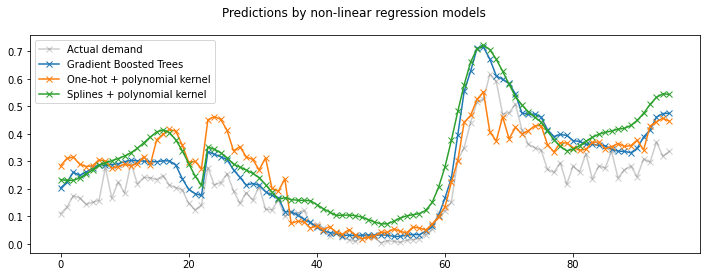

In [184]:
train_set, test_set = all_splits[2]


gbrt_pipeline.fit(X.iloc[train_set], y.iloc[train_set])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_set])

one_hot_poly_pipeline.fit(X.iloc[train_set], y.iloc[train_set])
one_hot_poly_predictions = one_hot_poly_pipeline.predict(X.iloc[test_set])

cyclic_spline_poly_pipeline.fit(X.iloc[train_set], y.iloc[train_set])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_set])

last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_set].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    gbrt_predictions[last_hours],
    "x-",
    label="Gradient Boosted Trees",
)
ax.plot(
    one_hot_poly_predictions[last_hours],
    "x-",
    label="One-hot + polynomial kernel",
)
ax.plot(
    cyclic_spline_poly_predictions[last_hours],
    "x-",
    label="Splines + polynomial kernel",
)
_ = ax.legend()

In [186]:
X.iloc[train_set].month.value_counts()

5    2913
3    2441
4    2303
6    1950
7     386
2       7
Name: month, dtype: int64

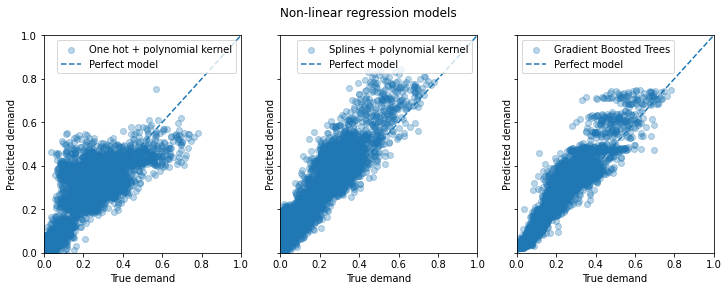

In [187]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    one_hot_poly_predictions,
    cyclic_spline_poly_predictions,
    gbrt_predictions,
]
labels = [
    "One hot + polynomial kernel",
    "Splines + polynomial kernel",
    "Gradient Boosted Trees",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_set].values, pred, alpha=0.3, label=label)
    ax.plot([0, 1], [0, 1], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [3]:
set_config(display='diagram')  

In [4]:
meteo_interpolator = ColumnTransformer(
    transformers=[("interpolation", interpolate_transformer, mmagns)],
    remainder="passthrough"
)
pipeline = Pipeline(
    steps=[("interpolation", meteo_interpolator)]
)

In [5]:
pipeline

Pipeline(steps=[('interpolation',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('interpolation',
                                                  FunctionTransformer(func=<function <lambda> at 0x7f02d8760160>),
                                                  ['temperatura',
                                                   'humedad_relativa',
                                                   'presion_barometrica',
                                                   'radiacion_solar',
                                                   'precipitacion', 'vientox',
                                                   'vientoy'])]))])

In [47]:
pd.DataFrame(pipeline.fit_transform(df), columns=mmagns+tmagns, index=df.index).head(20)

,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy,intensidad,ocupacion,vmed
fecha,,,,,,,,,,
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.0,0.0,57.0
2020-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,0.0,68.0
2020-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,0.0,65.0
2020-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,744.0,1.0,59.0
2020-01-01 01:00:00,1.100,97.00,955.0,1.0,0.0,-0.163056,0.608533,1212.0,2.0,62.0
2020-01-01 01:15:00,0.950,97.25,955.0,1.0,0.0,0.000221,0.393976,2196.0,5.0,62.0
2020-01-01 01:30:00,0.800,97.50,955.0,1.0,0.0,0.163499,0.179419,3120.0,9.0,60.0
2020-01-01 01:45:00,0.650,97.75,955.0,1.0,0.0,0.326776,-0.035138,3156.0,9.0,58.0
2020-01-01 02:00:00,0.500,98.00,955.0,1.0,0.0,0.490054,-0.249695,3060.0,10.0,55.0


In [46]:
df.head(20)

,intensidad,ocupacion,vmed,temperatura,humedad_relativa,presion_barometrica,radiacion_solar,precipitacion,vientox,vientoy
fecha,,,,,,,,,,
2020-01-01 00:00:00,264.0,0.0,57.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:15:00,252.0,0.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:30:00,252.0,0.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:45:00,744.0,1.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,1212.0,2.0,62.0,1.1,97.0,955.0,1.0,0.0,-0.163056,0.608533
2020-01-01 01:15:00,2196.0,5.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:30:00,3120.0,9.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:45:00,3156.0,9.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,3060.0,10.0,55.0,0.5,98.0,955.0,1.0,0.0,0.490054,-0.249695


In [29]:
interpolate_transformer.transform(df[["temperatura"]])

,temperatura
fecha,
2020-01-01 00:00:00,NaN
2020-01-01 00:15:00,NaN
2020-01-01 00:30:00,NaN
2020-01-01 00:45:00,NaN
2020-01-01 01:00:00,1.10
...,...
2021-12-31 22:45:00,6.25
2021-12-31 23:00:00,5.70
2021-12-31 23:15:00,5.70


/home/elena/PycharmProjects/tfm/tfm-env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


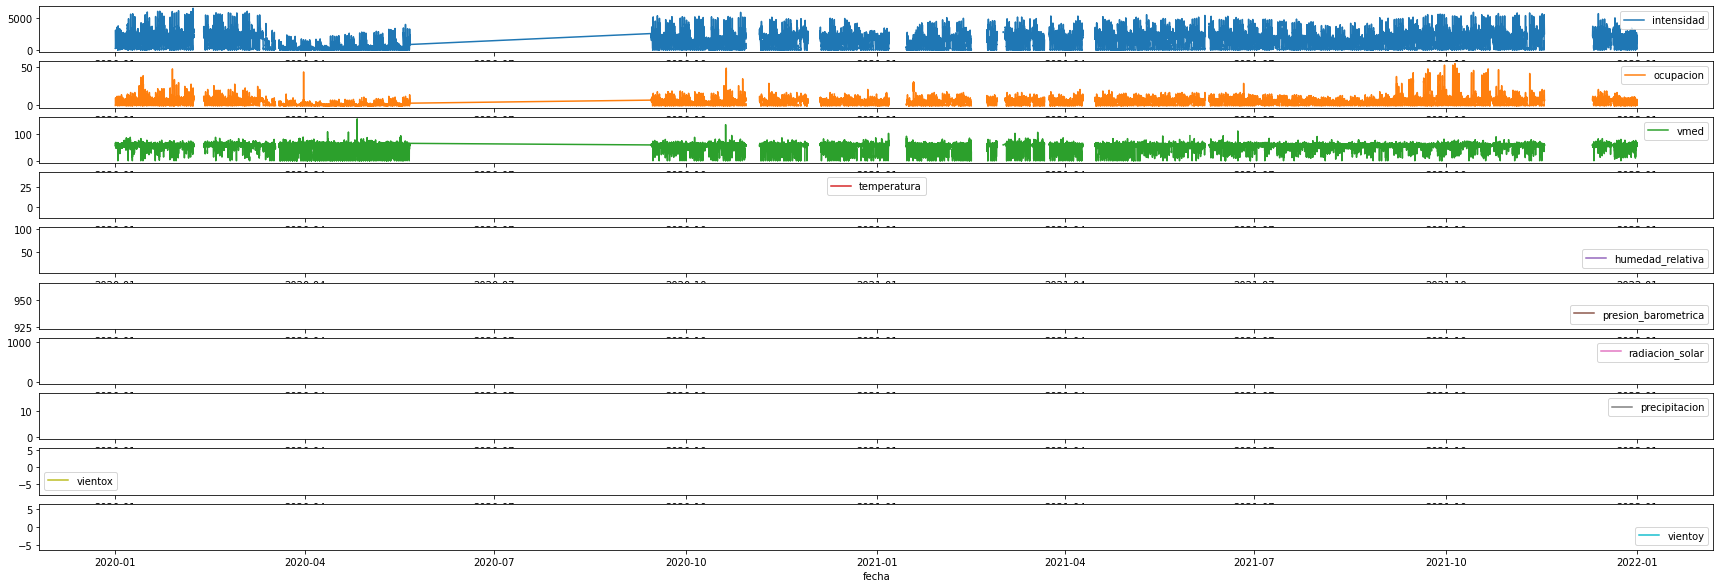

In [25]:
fig, ax = plt.subplots(figsize=(30, 10))
df.plot(subplots=True, ax=ax)
plt.show()

In [ ]:
df = df.sort_index()
df[mmagns] = df[mmagns].interpolate(method="linear", limit=4)

In [7]:
df[tmagns].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63793 entries, 2020-01-01 00:00:00 to 2021-12-31 23:45:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   intensidad  63787 non-null  float64
 1   ocupacion   55618 non-null  float64
 2   vmed        0 non-null      float64
dtypes: float64(3)
memory usage: 4.0 MB


In [10]:
df[tmagns].apply(make_stable_values_null).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63793 entries, 2020-01-01 00:00:00 to 2021-12-31 23:45:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   intensidad  63787 non-null  float64
 1   ocupacion   55618 non-null  float64
 2   vmed        0 non-null      float64
dtypes: float64(3)
memory usage: 4.0 MB


In [17]:
df.reset_index().fecha.apply(tipo_dia)

0        laborable
1        laborable
2        laborable
3        laborable
4        laborable
           ...    
63788    laborable
63789    laborable
63790    laborable
63791    laborable
63792    laborable
Name: fecha, Length: 63793, dtype: object

In [13]:
df["tipo_dia"] = df.index.values.apply(tipo_dia)
df.head()

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

In [9]:
pd.DataFrame(no_change_t.transform(df[tmagns]))

,0,1,2
0,64.0,NaN,NaN
1,69.0,NaN,NaN
2,95.0,NaN,NaN
3,171.0,NaN,NaN
4,240.0,NaN,NaN
...,...,...,...
63788,45.0,0.0,NaN
63789,65.0,1.0,NaN
63790,38.0,0.0,NaN
63791,47.0,0.0,NaN


In [46]:
df = df.merge(df.tipo_dia.str.get_dummies().iloc[:, [1, 2]], left_index=True, right_index=True)
del df['dia_semana'], df['tipo_dia']

In [48]:
tipo_dia_t.transform(df.index)

Int64Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
            ...
            4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
           dtype='int64', name='fecha', length=63793)

In [36]:
from custom_transformers import day_type

ImportError: cannot import name 'day_type' from 'custom_transformers' (/home/elena/PycharmProjects/tfm/notebooks/custom_transformers.py)

In [31]:
precipitacion = choice(precipitacion_v)
viento = choice(viento_v)
estacion = choice(estacion_v)
dia_semana = choice(temporal_v)
mes = choice(temporal_v)
dia = choice(temporal_v)
hora = choice(temporal_v)
prediction = choice(prediction_v)

pipeline = predicting_pipeline(precipitacion=precipitacion, viento=viento, estacion=estacion, prediction=prediction,
                               dia_semana=dia_semana, mes=mes, dia=dia, hora=hora)
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('passthrough',
                                                 ColumnTransformer(transformers=[('passthrough',
                                                                                  'passthrough',
                                                                                  ['temperatura',
                                                                                   'humedad_relativa',
                                                                                   'presion_barometrica',
                                                                                   'radiacion_solar',
                                                                                   'anyo'])])),
                                                ('precipitacion',
                                                 ColumnTransformer(transformers=[('precipitacion',
                                                                                  Pipeline(steps=[('functiontransformer',
                                                                                                   FunctionTransformer(...
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [18.],
       [20.],
       [22.],
       [24.],
       [26.],
       [28.],
       [30.]]),
                                                                                                    n_knots=16),
                                                                                  ['dia']),
                                                                                 ('hora',
                                                                                  SplineTransformer(extrapolation='periodic',
                                                                                                    knots=array([[ 0.],
       [ 2.],
       [ 4.],
       [ 6.],
       [ 8.],
       [10.],
       [12.],
       [14.],
       [16.],
       [18.],
       [20.],
       [22.],
       [24.]]),
                                                                                                    n_knots=13),
                                                                                  ['hora'])]))])),
                ('standardscaler', StandardScaler()),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [ ]:
"""
passthrough = ColumnTransformer(
    transformers=[
        ("passthrough", "passthrough", ["temperatura", "humedad_relativa", "presion_barometrica", "radiacion_solar", "anyo"])
    ]
)

def preprocessing_pipeline(precipitacion, viento, estacion, dia_semana, mes, dia, hora):
    return FeatureUnion([
    ("passthrough", passthrough),
    ("precipitacion", precipitacion_preprocessing(precipitacion)),
    ("viento", viento_selection(viento)),
    ("estacion", estacion_preprocessing(estacion)),
    ("bool", bool_preprocessing()),
    ("temporal", temporal_preprocessing(dia_semana, mes, dia, hora))
    ])
    
def bool_preprocessing():
    return ColumnTransformer([("bool", OrdinalEncoder(categories=bool_categories), bool_columns)])
"""


def temporal_preprocessing(dia_semana, mes, dia, hora):
    period_dict = dict(
        mes=12,
        dia_semana=7,
        dia=30,
        hora=24
    )

    def transformer(approach, period):
        if approach == "numeric":
            return "passthrough"
        elif approach == "one_hot":
            return OneHotEncoder(handle_unknown="ignore", sparse=False)
        elif approach == "trigonometric":
            return sincos(period)
        elif approach == "spline":
            return periodic_spline_transformer(period, n_splines=period//2)

    if hora == "one_hot":
        transformer_hora = make_pipeline(
            KBinsDiscretizer(n_bins=24, encode="ordinal"),
            transformer(hora, period_dict["hora"])
        )
    else:
        transformer_hora = transformer(hora, period_dict["hora"])
        
    transformers = [
        ("dia_semana", transformer(dia_semana, period_dict["dia_semana"]), ["dia_semana"]),
        ("mes", transformer(mes, period_dict["mes"]), ["mes"]),
        ("dia", transformer(dia, period_dict["dia"]), ["dia"]),
        ("hora", transformer_hora, ["hora"]),
    ]
    return ColumnTransformer(transformers)